In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# RandomizedSearchCV
# 1. 因为是sklearn的接口，转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    #因为不知道第一个输入的shape是多大的，因此我们需要单独从for循环里拿出来，for循环里的是输出再次作为输入
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

#KerasRegressor返回一个sk的model,build_fn是一个回调函数
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
#这是对sk封装tf的一个测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.1275 - val_loss: 0.7655
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.6533 - val_loss: 0.6443
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5643 - val_loss: 0.5750
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5124 - val_loss: 0.5321
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4859 - val_loss: 0.5041
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4670 - val_loss: 0.4905
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4532 - val_loss: 0.4764
Epoch 8/10
363/363 [==============================] - 2s 4ms/step - loss: 0.4465 - val_loss: 0.4867
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4381 - val_loss: 0.4799
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4325 - val_loss: 0.4513

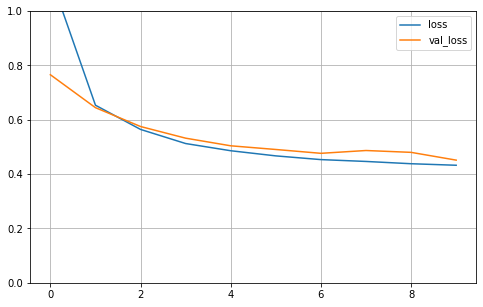

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [18]:
#scipy也是sk中的
from scipy.stats import reciprocal
# 分布函数
# f(x) = 1/(x*log(b/a)) a <= x <= b

#sk 0.21.3版本可以用这种列表
# param_distribution = {
#     "hidden_layers":[1, 2, 3, 4],
#     "layer_size": np.arange(1, 100),
#     "learning_rate": reciprocal(1e-4, 1e-2),
# }
#最新版本只能用普通列表
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": [5, 10, 20, 30],
    "learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 1,#多少个参数集合
                                      n_jobs = 1)
grid_search_cv =GridSearchCV(sklearn_model,param_distribution)
# random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
#                      validation_data = (x_valid_scaled, y_valid),
#                      callbacks = callbacks)

grid_search_cv.fit(x_train_scaled, y_train, epochs = 5,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)
# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 3.7302 - val_loss: 3.4133
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 3.0389 - val_loss: 2.7870
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.4989 - val_loss: 2.2996
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.0779 - val_loss: 1.9203
Epoch 5/5
73/73 [==============================] - 0s 940us/step - loss: 1.5393
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 6.1830 - val_loss: 5.6169
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.8607 - val_loss: 4.5105
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.9263 - val_loss: 3.7126
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.2467 - val_loss: 3.1173
Epoch 5/5
73/73 [==============================] - 0s 862us/step - loss: 2.5716
Epoch 1/5
291/291 [=============================

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6719 - val_loss: 0.7036
Epoch 5/5
73/73 [==============================] - 0s 838us/step - loss: 0.6344
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.5991 - val_loss: 0.6828
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6226 - val_loss: 0.5921
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5432 - val_loss: 0.5496
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5144 - val_loss: 0.5280
Epoch 5/5
73/73 [==============================] - 0s 816us/step - loss: 0.4424
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.3555 - val_loss: 0.7503
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6607 - val_loss: 0.6934
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6406 - val_loss: 0.6523
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 3.9855 - val_loss: 3.4577
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.4852 - val_loss: 3.0971
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0738 - val_loss: 2.7800
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.7259 - val_loss: 2.5052
Epoch 5/5
73/73 [==============================] - 0s 799us/step - loss: 2.0080
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 5.7577 - val_loss: 5.5803
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.1666 - val_loss: 5.0252
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.6810 - val_loss: 4.5657
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.2764 - val_loss: 4.1796
Epoch 5/5
73/73 [==============================] - 0s 828us/step - loss: 4.2320
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4846 - val_loss: 0.5238
Epoch 5/5
73/73 [==============================] - 0s 853us/step - loss: 0.4925
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 2.1541 - val_loss: 0.6098
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5238 - val_loss: 0.5372
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4845 - val_loss: 0.5049
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4646 - val_loss: 0.4894
Epoch 5/5
73/73 [==============================] - 0s 875us/step - loss: 0.4604
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.2104 - val_loss: 0.6460
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.5786
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5213 - val_loss: 0.5050
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 1ms/step - loss: 5.6039 - val_loss: 5.4202
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.9116 - val_loss: 4.7932
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.3528 - val_loss: 4.2834
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.8954 - val_loss: 3.8614
Epoch 5/5
73/73 [==============================] - 0s 932us/step - loss: 3.6516
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 5.9114 - val_loss: 5.7610
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.1139 - val_loss: 5.0161
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.4701 - val_loss: 4.4086
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.9461 - val_loss: 3.9124
Epoch 5/5
73/73 [==============================] - 0s 809us/step - loss: 3.4299
Epoch 1/5
291/291 [==============================] - 0s 1m

Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4059 - val_loss: 0.4234
Epoch 5/5
73/73 [==============================] - 0s 865us/step - loss: 0.4094
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 0.9890 - val_loss: 0.6240
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6633 - val_loss: 0.5386
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4771 - val_loss: 0.4996
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4470 - val_loss: 0.4610
Epoch 5/5
73/73 [==============================] - 0s 988us/step - loss: 0.4408
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7091 - val_loss: 0.5298
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4525 - val_loss: 0.4592
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4188 - val_loss: 0.4325
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 1ms/step - loss: 2.3769 - val_loss: 1.2962
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9164 - val_loss: 0.8766
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7566 - val_loss: 0.8033
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7038 - val_loss: 0.7584
Epoch 5/5
73/73 [==============================] - 0s 814us/step - loss: 0.6516
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 2.2894 - val_loss: 1.1511
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8092 - val_loss: 0.7775
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6664 - val_loss: 0.7098
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6269 - val_loss: 0.6807
Epoch 5/5
73/73 [==============================] - 0s 806us/step - loss: 0.6221
Epoch 1/5
291/291 [==============================] - 0s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1234 - val_loss: 4.0810
Epoch 5/5
73/73 [==============================] - 0s 794us/step - loss: 3.4514
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 4.6528 - val_loss: 4.1463
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.4272 - val_loss: 3.0425
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.5122 - val_loss: 2.2247
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.8773 - val_loss: 1.6896
Epoch 5/5
73/73 [==============================] - 0s 805us/step - loss: 1.3457
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 4.4006 - val_loss: 4.2020
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.6753 - val_loss: 3.6403
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.1892 - val_loss: 3.2597
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 1.1325 - val_loss: 0.7797
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6743 - val_loss: 0.6631
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5857 - val_loss: 0.5973
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5373 - val_loss: 0.5552
Epoch 5/5
73/73 [==============================] - 0s 848us/step - loss: 0.5008
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 1.7168 - val_loss: 0.8531
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7094 - val_loss: 0.6843
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6398 - val_loss: 0.6199
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5800 - val_loss: 0.5875
Epoch 5/5
73/73 [==============================] - 0s 843us/step - loss: 0.5340
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 3.2823 - val_loss: 3.2222
Epoch 5/5
73/73 [==============================] - 0s 818us/step - loss: 2.6923
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 3.8150 - val_loss: 3.8281
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 3.4994 - val_loss: 3.5231
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.2152 - val_loss: 3.2501
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 2.9620 - val_loss: 3.0047
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.5893
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 3.6814 - val_loss: 3.5186
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 3.2340 - val_loss: 3.0951
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 2.8571 - val_loss: 2.7379
Epoch 4/5
291/291 [==============================]

291/291 [==============================] - 0s 2ms/step - loss: 0.9669 - val_loss: 0.6020
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5496 - val_loss: 0.5286
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4793 - val_loss: 0.4698
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4465 - val_loss: 0.4473
Epoch 5/5
73/73 [==============================] - 0s 889us/step - loss: 0.3953
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8343 - val_loss: 0.6022
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5146 - val_loss: 0.5177
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4738 - val_loss: 0.4948
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4515 - val_loss: 0.4555
Epoch 5/5
73/73 [==============================] - 0s 875us/step - loss: 0.4279
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7984 - val_loss: 3.7881
Epoch 5/5
73/73 [==============================] - 0s 834us/step - loss: 3.2786
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 2.1391 - val_loss: 1.1402
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9208 - val_loss: 0.8647
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7857 - val_loss: 0.7936
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7283 - val_loss: 0.7446
Epoch 5/5
73/73 [==============================] - 0s 955us/step - loss: 0.6427
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 2.2712 - val_loss: 1.1007
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8588 - val_loss: 0.8097
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7178 - val_loss: 0.7381
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 1ms/step - loss: 1.0129 - val_loss: 0.5750
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4685 - val_loss: 0.4712
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4345 - val_loss: 0.4533
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4204 - val_loss: 0.4478
Epoch 5/5
73/73 [==============================] - 0s 833us/step - loss: 0.4275
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 6.1416 - val_loss: 4.8453
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7696 - val_loss: 3.2075
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.6083 - val_loss: 2.3301
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.9735 - val_loss: 1.8416
Epoch 5/5
73/73 [==============================] - 0s 822us/step - loss: 1.4930
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6738 - val_loss: 0.7328
Epoch 5/5
73/73 [==============================] - 0s 840us/step - loss: 0.6761
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 2.5696 - val_loss: 1.2031
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.8723 - val_loss: 0.8150
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6926 - val_loss: 0.7254
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6392 - val_loss: 0.6828
Epoch 5/5
73/73 [==============================] - 0s 808us/step - loss: 0.6403
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9834 - val_loss: 0.6708
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5775 - val_loss: 0.5637
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5022 - val_loss: 0.5133
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 1ms/step - loss: 4.2830 - val_loss: 4.3419
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.7457 - val_loss: 3.8645
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.2916 - val_loss: 3.4679
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.9200 - val_loss: 3.1486
Epoch 5/5
73/73 [==============================] - 0s 803us/step - loss: 3.0184
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 5.1500 - val_loss: 4.9031
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 4.2187 - val_loss: 4.0588
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 3.4726 - val_loss: 3.3529
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.8537 - val_loss: 2.7727
Epoch 5/5
73/73 [==============================] - 0s 826us/step - loss: 2.2558
Epoch 1/5
291/291 [==============================] - 0s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6335 - val_loss: 0.6457
Epoch 5/5
73/73 [==============================] - 0s 795us/step - loss: 0.5698
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 1.2458 - val_loss: 0.6216
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5497 - val_loss: 0.5592
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5063 - val_loss: 0.5267
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4831 - val_loss: 0.5003
Epoch 5/5
73/73 [==============================] - 0s 834us/step - loss: 0.4788
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.5244 - val_loss: 0.8249
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7370 - val_loss: 0.7401
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6676 - val_loss: 0.7065
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 7.1078 - val_loss: 6.9873
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 6.2327 - val_loss: 6.2259
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 5.6163 - val_loss: 5.6641
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 5.1425 - val_loss: 5.2175
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 4.6538
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 6.3171 - val_loss: 6.2925
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.8178 - val_loss: 5.8345
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 5.4099 - val_loss: 5.4521
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 5.0635 - val_loss: 5.1204
Epoch 5/5
73/73 [==============================] - 0s 838us/step - loss: 4.4484
Epoch 1/5
291/291 [==============================] - 1s 2ms/

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4576 - val_loss: 0.4724
Epoch 5/5
73/73 [==============================] - 0s 821us/step - loss: 0.4643
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9713 - val_loss: 0.6675
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5828 - val_loss: 0.5753
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4995 - val_loss: 0.5683
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4556 - val_loss: 0.4717
Epoch 5/5
73/73 [==============================] - 0s 870us/step - loss: 0.4363
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.0277 - val_loss: 0.6353
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5633 - val_loss: 0.5627
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4956 - val_loss: 0.4893
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 1s 2ms/step - loss: 2.3127 - val_loss: 1.3196
Epoch 2/5
291/291 [==============================] - 1s 4ms/step - loss: 1.0243 - val_loss: 0.8945
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7863 - val_loss: 0.7925
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.7214 - val_loss: 0.7498
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6429
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 2.7493 - val_loss: 1.2531
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9447 - val_loss: 0.9045
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7855 - val_loss: 0.8047
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7246 - val_loss: 0.7587
Epoch 5/5
73/73 [==============================] - 0s 836us/step - loss: 0.6805
Epoch 1/5
291/291 [==============================] - 1s 2ms/

291/291 [==============================] - 0s 1ms/step - loss: 2.7719 - val_loss: 2.5585
Epoch 5/5
73/73 [==============================] - 0s 867us/step - loss: 1.8775
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 4.4904 - val_loss: 3.8775
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.0246 - val_loss: 2.6665
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.1599 - val_loss: 1.9843
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.6823 - val_loss: 1.6126
Epoch 5/5
73/73 [==============================] - 0s 827us/step - loss: 1.2938
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 5.1379 - val_loss: 4.6250
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.8187 - val_loss: 3.4496
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.8554 - val_loss: 2.5930
Epoch 4/5
291/291 [==============================] - 0s 1m

291/291 [==============================] - 1s 2ms/step - loss: 1.0075 - val_loss: 0.6623
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5874 - val_loss: 0.5574
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5029 - val_loss: 0.5075
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4611 - val_loss: 0.4956
Epoch 5/5
73/73 [==============================] - 0s 840us/step - loss: 0.3968
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 1.0852 - val_loss: 0.6511
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5616 - val_loss: 0.5565
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4893 - val_loss: 0.5017
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4541 - val_loss: 0.5052
Epoch 5/5
73/73 [==============================] - 0s 817us/step - loss: 0.4362
Epoch 1/5
291/291 [==============================] - 0s 1m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.4261 - val_loss: 2.3892
Epoch 5/5
73/73 [==============================] - 0s 807us/step - loss: 2.0336
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 6.0948 - val_loss: 6.0442
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.6170 - val_loss: 5.6368
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 5.2630 - val_loss: 5.3146
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.9714 - val_loss: 5.0399
Epoch 5/5
73/73 [==============================] - 0s 855us/step - loss: 4.4643
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 5.9366 - val_loss: 5.9044
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.3492 - val_loss: 5.3699
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.8846 - val_loss: 4.9374
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 1.5623 - val_loss: 0.9206
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7592 - val_loss: 0.7417
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6614 - val_loss: 0.6966
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6066 - val_loss: 0.6376
Epoch 5/5
73/73 [==============================] - 0s 777us/step - loss: 0.5561
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 0.9666 - val_loss: 0.7402
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6313 - val_loss: 0.6234
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5105 - val_loss: 0.5168
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4527 - val_loss: 0.4486
Epoch 5/5
73/73 [==============================] - 0s 800us/step - loss: 0.3988
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.1080 - val_loss: 4.0474
Epoch 5/5
73/73 [==============================] - 0s 826us/step - loss: 3.2794
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 5.3168 - val_loss: 5.4574
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 5.0555 - val_loss: 5.1965
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 4.8093 - val_loss: 4.9497
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 4.5760 - val_loss: 4.7161
Epoch 5/5
73/73 [==============================] - 0s 853us/step - loss: 4.3971
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 2.0899 - val_loss: 0.9596
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7952 - val_loss: 0.7881
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6954 - val_loss: 0.7286
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 0.9180 - val_loss: 0.6265
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5453 - val_loss: 0.5309
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4696 - val_loss: 0.4712
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4249 - val_loss: 0.4402
Epoch 5/5
73/73 [==============================] - 0s 788us/step - loss: 0.4392
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 0.8064 - val_loss: 0.5649
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4831 - val_loss: 0.4796
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4289 - val_loss: 0.4382
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4109 - val_loss: 0.4534
Epoch 5/5
73/73 [==============================] - 0s 802us/step - loss: 0.4163
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6767 - val_loss: 0.7176
Epoch 5/5
73/73 [==============================] - 0s 799us/step - loss: 0.6556
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 2.2217 - val_loss: 1.2391
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.9393 - val_loss: 0.8283
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7009 - val_loss: 0.7145
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6327 - val_loss: 0.6817
Epoch 5/5
73/73 [==============================] - 0s 861us/step - loss: 0.6218
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 2.0132 - val_loss: 0.9732
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.7810 - val_loss: 0.7751
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6754 - val_loss: 0.7184
Epoch 4/5
291/291 [=============================

291/291 [==============================] - 0s 2ms/step - loss: 4.7971 - val_loss: 4.3465
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5784 - val_loss: 3.2440
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.6579 - val_loss: 2.4416
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 2.0227 - val_loss: 1.9207
Epoch 5/5
73/73 [==============================] - 0s 848us/step - loss: 1.4650
Epoch 1/5
291/291 [==============================] - 0s 2ms/step - loss: 4.7511 - val_loss: 4.2873
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 3.5567 - val_loss: 3.1497
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 2.5669 - val_loss: 2.2929
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 1.8765 - val_loss: 1.7832
Epoch 5/5
73/73 [==============================] - 0s 933us/step - loss: 1.7238
Epoch 1/5
291/291 [==============================] - 0s 2m

Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4224 - val_loss: 0.4368
Epoch 5/5
73/73 [==============================] - 0s 777us/step - loss: 0.4124
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.1924 - val_loss: 0.6382
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5583 - val_loss: 0.5605
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5016 - val_loss: 0.5087
Epoch 4/5
291/291 [==============================] - 0s 1ms/step - loss: 0.4564 - val_loss: 0.4666
Epoch 5/5
73/73 [==============================] - 0s 768us/step - loss: 0.4198
Epoch 1/5
291/291 [==============================] - 0s 1ms/step - loss: 1.4115 - val_loss: 0.7713
Epoch 2/5
291/291 [==============================] - 0s 1ms/step - loss: 0.6211 - val_loss: 0.5936
Epoch 3/5
291/291 [==============================] - 0s 1ms/step - loss: 0.5215 - val_loss: 0.5280
Epoch 4/5
291/291 [=============================

GridSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f98646187f0>,
             param_grid={'hidden_layers': [1, 2, 3, 4],
                         'layer_size': [5, 10, 20, 30],
                         'learning_rate': [0.0001, 5e-05, 0.001, 0.005, 0.01]})

In [19]:
# print(random_search_cv.best_params_)
# print(random_search_cv.best_score_)
# print(random_search_cv.best_estimator_)

print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 30, 'learning_rate': 0.01}
-0.38417415618896483


In [21]:
# model = random_search_cv.best_estimator_.model
# model.evaluate(x_test_scaled, y_test)

model = grid_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 877us/step - loss: 0.3872


0.3872361183166504